In [106]:
import glob
import numpy as np 
import time
import math
import random
from scipy import linalg as LA
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from matplotlib import colors
from datetime import datetime

## Reading cleaned csv files

### User i is data_1$[i]$ in the following

In [2]:
data_1 = [0] * 57
for i in range(len(data_1)):
    fnames = glob.glob('labeled csv Geolife/'+str(i)+'/*.csv')
    data_1[i] = np.array([np.loadtxt(f, delimiter=',')[1:] for f in fnames])
data_1 = np.array(data_1)

In [3]:
fnames = glob.glob('labeled csv Geolife/**/*.csv')
len(fnames)

3572

### Users are stacked together in data_2 below

In [4]:
data_2 = []
fnames = glob.glob('labeled csv Geolife/**/*.csv')
for f in fnames:
    data_2.append(np.loadtxt(f, delimiter=',')[1:])
data_2 = np.array(data_2)

In [5]:
A = np.array([len(data_2[i]) for i in range(len(data_2))])
min(A), max(A)

(3, 40392)

### Removing segments with length less than 1e-10 because of numerical precision

In [6]:
data_3 = [0] * len(data_2)
h = 1e-10
c = 0
for i in range(len(data_2)):
    p1 = data_2[i][:-1]
    p2 = data_2[i][1:]
    L = ((p2[:,:2]-p1[:,:2])*(p2[:,:2]-p1[:,:2])).sum(axis =1)
    I = np.where(L > h)[0]
    J = np.where(L < h)[0]
    if len(J) > 0:
        c += 1
    p1 = p1[I]
    p2 = p2[I]
    if len(I) == 0:
        print(i)
    gamma = np.concatenate((p1, p2[-1].reshape(1,4)), 0) 
    if len(gamma) > 0:
        data_3[i] = gamma
    data_3[i] = np.array(data_3[i])
data_3 = np.array(data_3)
c

3182

In [7]:
A = np.array([len(data_3[i]) for i in range(len(data_3))])
min(A), max(A), np.where(A > 40000)[0]

(2, 40323, array([1380]))

# Partitioning trajectories to less than 20 minutes long

In [8]:
# 24 * 60 * (days_date('1899/12/30 2:50:06') - days_date('1899/12/30 2:20:06')) == 20 min
Time = np.zeros(len(data_3))
for i in range(len(data_3)):
    Time[i] = 24 * 60 * sum(data_3[i][:,2][1:] - data_3[i][:,2][:-1]) # = 20 minutes 
min(Time), max(Time), np.where(Time>2000)

(0.08333337376825511, 2085.283333301777, (array([2940]),))

In [9]:
J = np.where(Time>20)[0]
len(J)

2365

In [10]:
def partition(trajectory):
    trajectories = []
    a = 24 * 60 * sum(trajectory[:,2][1:] - trajectory[:,2][:-1])
    if a <= 20:
        return np.array(trajectory.reshape(1, len(trajectory), 4))
    else: 
        i = 0
        while a > 20:
            j = i + 0
            val = 0
            while val < 20: 
                if i < len(trajectory) - 1:
                    temp = val + 0
                    val += 24 * 60 * (trajectory[:,2][1:][i] - trajectory[:,2][:-1][i])
                    i += 1
                else: 
                    break
            if len(trajectory[j:i-1]) > 0:
                trajectories.append(trajectory[j:i-1])
            a = a - val
        if len(trajectory[i:]) > 0:
            trajectories.append(trajectory[i:])
    return trajectories

In [11]:
# Check to see if partitioning into less than 20 minutes worked correctly
for j in J:
    A = partition(data_3[j])
    B = np.array([24 * 60 * sum(A[i][:,2][1:] - A[i][:,2][:-1]) for i in range(len(A))])
    I = np.where(B > 20)[0]
    if len(I) > 0: 
        print(j)

### data_4 below is the array of trajectories having less than 20 minutes long

In [12]:
data_4 = []
for i in range(len(data_3)):
    A = partition(data_3[i])
    for j in range(len(A)):
        data_4.append(A[j])
data_4 = np.array(data_4)

In [13]:
data_4.shape, data_4[0].shape

((11833,), (360, 4))

In [14]:
I = np.where(np.array([len(data_4[i]) for i in range(len(data_4))]) != 1)[0]
data_4 = data_4[I]
len(data_4)

11751

In [15]:
int1 = np.vectorize(int)
data_5 = []
c = 0
for i in range(len(data_4)):
    if len(set(int1(data_4[i][:,3]))) < 2: 
        data_5.append(data_4[i])
        c += 1
data_5 = np.array(data_5)
c

10039

In [16]:
data_6 = []
d = 0
for i in range(len(data_4)):
    if len(set(int1(data_4[i][:,3]))) == 2: 
        data_6.append(data_4[i])
        d += 1
data_6 = np.array(data_6)
d

1671

In [17]:
# a:b
# a is the number of labels in a trajectory
# b is the number of trajectries with a labels
D = {1:10121, 2:1671, 3:39, 4:2, 5:0}

In [18]:
Modes = ['walk', 'bike', 'bus', 'driving', 'train']

In [19]:
C = []
for j in range(5):
    c = 0
    for i in range(len(data_5)):
        if data_5[i][0][-1] == j:
            c += 1
    C.append(c)
print("number of trajectories of length 1 with label 0, 1, 2, 3, 4:", C)

number of trajectories of length 1 with label 0, 1, 2, 3, 4: [3383, 1650, 1929, 2214, 863]


# Creating trajectories with 3, 4, 5 labels

### Preparing length 2 sentences

In [20]:
data_7 = [0] * len(data_6)
for i in range(len(data_6)):
    I = list(set(data_6[i][:,3]))
    data_7[i] = []
    J1 = np.where(data_6[i][:,3] == I[0])
    J2 = np.where(data_6[i][:,3] == I[1])
    D1 = data_6[i][J1]
    D2 = data_6[i][J2]
    data_7[i].append(D1)
    data_7[i].append(D2)
data_7 = np.array(data_7)
data_7.shape

(1671, 2)

### Creating sentences of length 3, 4, 5 from 10039 length 1 trajectories

In [21]:
data = []

n_1 = 1000 # number of length 1 sentences
n_2 = 1000 # len(data_7)# 1671: number of length 2 sentences
n_3 = 800 # number of length 3 sentences
n_4 = 700 # number of length 4 sentences
n_5 = 1900 # number of length 5 sentences

for i in range(n_1):
    I = np.random.randint(0, 10039, size=1)
    data.append(data_5[I])
    
for i in range(n_2): 
    data.append(data_7[i])

for i in range(n_3):
    I = np.random.randint(0, 10039, size=3)
    data.append(data_5[I])

for i in range(n_4):
    I = np.random.randint(0, 10039, size=4)
    data.append(data_5[I])
    
for i in range(n_5):
    I = np.random.randint(0, 10039, size=5)
    data.append(data_5[I])
    
data = np.array(data)
data.shape

(5400,)

### Length of sentences

In [22]:
print(data[0].shape, data[n_1].shape, data[n_1+n_2].shape, data[n_1+n_2+n_3].shape, 
      data[n_1+n_2+n_3+n_4].shape)

(1,) (2,) (3,) (4,) (5,)


# Functions needed for CMM

### Feature Mappings

$x = (x_1, x_2, \ldots, x_n)$

$y = (y_1, y_2, \ldots, y_n) \in \{0,1,2,3,4\}^n$

If $x_i = [(a_0, b_0, t_0), \ldots, (a_m, b_m, t_m)]$, where $a_j$ is latitude, $b_j$ is longitude and $t_j$ is time, then 
$$\displaystyle \text{length}_i = \frac{1}{m} \sum_{j=1}^m \|(a_j, b_j) - (a_{j-1}, b_{j-1})\|_2,$$
$$\text{velocity}_i = \frac{1}{m} \sum_{j=1}^m \frac{\|(a_j, b_j) - (a_{j-1}, b_{j-1})\|_2}{t_j},$$
$$\text{acceleration}_i = \frac{1}{m} \sum_{j=1}^m \frac{\|(a_j, b_j) - (a_{j-1}, b_{j-1})\|_2}{t_j^2}.$$

#Notice: I have divded the acceleration by 1e10 for all data. 

### $\phi_1(x, y) = (\text{length}_i, \text{velocity}_i, \text{acceleration}_i, y_i)_{i=1}^n \in \mathbb{R}^{4n}$

### $\phi_2(x, y) = (\text{start point}_i, \text{end point}_i, \text{length}_i, \text{velocity}_i, \text{acceleration}_i, y_i)_{i=1}^n \in \mathbb{R}^{8n}$

### Feature Mapping $\phi_1$

In [23]:
def featureMapping1(data):
    Data = [0] * len(data)
    for i in range(len(data)):
        Data[i] = []
        for j in range(len(data[i])):
            D = data[i][j]
            segments = D[:,:2][1:] - D[:,:2][:-1]
            segments_lengths = np.sqrt(np.sum((segments)**2, 1))
            I = np.where(segments_lengths > 1e-8)
            D = D[I]
            if len(D) > 1:
                segments = D[:,:2][1:] - D[:,:2][:-1]
                segments_lengths = np.sqrt(np.sum((segments)**2, 1))
                length = np.sum(segments_lengths)/len(D) + 1e-10
                time = D[:,2][1:] - D[:,2][:-1] + 1e-10
                velocities = segments_lengths/time
                velocity = np.mean(velocities)
                accelerations = segments_lengths/time**2
                acceleration = np.mean(accelerations)/1e10
                y = D[0][-1]
                array = np.array([length, velocity, acceleration, y])
                Data[i].append(array)
        Data[i] = np.array(Data[i])

    Data = np.array(Data)
    K = np.array([len(Data[i]) for i in range(len(Data))])
    J = np.where(K > 0)
    Data = Data[J]
    return Data

### Feature Mapping $\phi_2$

In [24]:
def featureMapping2(data):
    Data = [0] * len(data)
    for i in range(len(data)):
        Data[i] = []
        for j in range(len(data[i])):
            D = data[i][j]
            segments = D[:,:2][1:] - D[:,:2][:-1]
            segments_lengths = np.sqrt(np.sum((segments)**2, 1))
            I = np.where(segments_lengths > 1e-8)
            D = D[I]
            if len(D) > 1:
                segments = D[:,:2][1:] - D[:,:2][:-1]
                segments_lengths = np.sqrt(np.sum((segments)**2, 1))
                length = np.sum(segments_lengths)/len(D) + 1e-10
                time = D[:,2][1:] - D[:,2][:-1] + 1e-10
                velocities = segments_lengths/time
                velocity = np.mean(velocities)
                accelerations = segments_lengths/time**2
                acceleration = np.mean(accelerations)/1e10
                y = D[0][-1]
                array = np.array([length, velocity, acceleration, 
                                  D[0][0], D[0][1], D[-1][0], D[-1][1], y])
                Data[i].append(array)
        Data[i] = np.array(Data[i])

    Data = np.array(Data)
    K = np.array([len(Data[i]) for i in range(len(Data))])
    J = np.where(K > 0)
    Data = Data[J]
    return(Data)

# Feature mapping using landmarks

$x = (x_1, x_2, \ldots, x_n)$

$y = (y_1, y_2, \ldots, y_n) \in \{0,1,2,3,4\}^n$

If $x_i = [(a_0, b_0, t_0), \ldots, (a_m, b_m, t_m)]$, where $a_j$ is latitude, $b_j$ is longitude and $t_j$ is time, then 
$$\displaystyle \text{length}_i = \frac{1}{m} \sum_{j=1}^m \|(a_j, b_j) - (a_{j-1}, b_{j-1})\|_2,$$
$$\text{velocity}_i = \frac{1}{m} \sum_{j=1}^m \frac{\|(a_j, b_j) - (a_{j-1}, b_{j-1})\|_2}{t_j},$$
$$\text{acceleration}_i = \frac{1}{m} \sum_{j=1}^m \frac{\|(a_j, b_j) - (a_{j-1}, b_{j-1})\|_2}{t_j^2}.$$

#Notice: I have divded the acceleration by 1e10 for all data. 

#### Now we would like to use a feature mapping introduced in the following paper:

``Jeff M. Phillips and Pingfan Tang. Simple distances for trajectories via landmarks. In ACM GIS SIGSPATIAL, 2019.''

Following the paper, let $q \in \mathbb{R}^2$ be a landmark and $\gamma$ be a trajectory in $\mathbb{R}^2$. We define 
$$v_q(\gamma) = {\rm dist}(\gamma, q) = min_{p \in \gamma} \|q - p\|_2.$$

We randomly choose $m$ (here $m=20$ will be used) landmaks in $\mathbb{R}^2$ around trajectories and call them $Q$, so $Q=\{q_1, q_2, \ldots, q_m\}$. Then we define the feature mapping $v_Q$ by 
$$v_Q(\gamma) = (v_{q_1}(\gamma), v_{q_2}(\gamma), \ldots, v_{q_m}(\gamma)) \in \mathbb{R}^m.$$

Then we combine this feature mapping with $\phi_1$ and $\phi_2$ to get the following feature mappings:

### $\phi_3(x, y) = (v_Q(x_i), y_i)_{i=1}^n \in \mathbb{R}^{(m+1)n}$

### $\phi_4(x, y) = (v_Q(x_i), \text{length}_i, \text{velocity}_i, \text{acceleration}_i, y_i)_{i=1}^n \in \mathbb{R}^{(m+4)n}$

### $\phi_5(x, y) = (v_Q(x_i), \text{start point}_i, \text{end point}_i, \text{length}_i, \text{velocity}_i, \text{acceleration}_i, y_i)_{i=1}^n \in \mathbb{R}^{(m+8)n}$

### Landmark Feature Mapping $v_Q$

In [25]:
def featureMap_v_Q(Q, gamma):
    
    p2 = gamma[1:]
    p1 = gamma[:-1]
    L = np.sqrt(((p2-p1)*(p2-p1)).sum(axis =1))
    II = np.where(L>10e-8)[0]
    L = L[II]
    p1 = p1[II]
    p2 = p2[II]
    w = (p1-p2)*(-1,1)/(L*np.ones((2,1))).T
    w[:,[0, 1]] = w[:,[1, 0]]
    
    dist_dot = np.sum(w * (Q.reshape(len(Q),1,2) - p1), axis=2)
    
    x = abs(dist_dot.copy())
    R = (L**2).reshape(-1,1)
    u = p1 + ((((np.sum(((Q.reshape(len(Q),1,2) - p1) * (p2 - p1)),axis=2).reshape(len(Q)
                ,-1,1,1) * (p2-p1).reshape(len(p2-p1),1,2))).reshape(len(Q),len(p1),2))/R)
    
    G = np.sqrt(np.sum((u-p1)*(u-p1), axis=2))
    H = np.sqrt(np.sum((u-p2)*(u-p2), axis=2))
    d1 = np.sqrt(np.sum((Q.reshape(len(Q),1,2)-p1)*(Q.reshape(len(Q),1,2)-p1), axis=2))
    d2 = np.sqrt(np.sum((Q.reshape(len(Q),1,2)-p2)*(Q.reshape(len(Q),1,2)-p2), axis=2))

    dist = np.where(abs(G + H - L) < np.ones(len(L)) * (10e-8), x, np.minimum(d1, d2))

    j = np.argmin(dist, axis =1)
    dist_weighted = dist[np.arange(len(dist)),j]
    
    return dist_weighted.reshape(len(Q))

### FeatureMapping3

In [26]:
def featureMapping3(data, Q):
    Data = [0] * len(data)
    for i in range(len(data)):
        Data[i] = []
        for j in range(len(data[i])):
            D = data[i][j]
            segments = D[:,:2][1:] - D[:,:2][:-1]
            segments_lengths = np.sqrt(np.sum((segments)**2, 1))
            I = np.where(segments_lengths > 1e-8)
            D = D[I]
            if len(D) > 1:
                segments = D[:,:2][1:] - D[:,:2][:-1]
                segments_lengths = np.sqrt(np.sum((segments)**2, 1))
                length = np.sum(segments_lengths)/len(D) + 1e-10
                time = D[:,2][1:] - D[:,2][:-1] + 1e-10
                velocities = segments_lengths/time
                velocity = np.mean(velocities)
                accelerations = segments_lengths/time**2
                acceleration = np.mean(accelerations)/1e10
                y = D[0][-1]
                array_vel_acc = np.array([y])
                mapped_v_Q_D = featureMap_v_Q(Q, D[:,:2])
                array = np.concatenate((mapped_v_Q_D, array_vel_acc), 0)
                Data[i].append(array)
        Data[i] = np.array(Data[i])

    Data = np.array(Data)
    K = np.array([len(Data[i]) for i in range(len(Data))])
    J = np.where(K > 0)
    Data = Data[J]
    return Data

### Feature mapping composed of $v_Q$ and featureMapping1

In [27]:
def featureMapping4(data, Q):
    Data = [0] * len(data)
    for i in range(len(data)):
        Data[i] = []
        for j in range(len(data[i])):
            D = data[i][j]
            segments = D[:,:2][1:] - D[:,:2][:-1]
            segments_lengths = np.sqrt(np.sum((segments)**2, 1))
            I = np.where(segments_lengths > 1e-8)
            D = D[I]
            if len(D) > 1:
                segments = D[:,:2][1:] - D[:,:2][:-1]
                segments_lengths = np.sqrt(np.sum((segments)**2, 1))
                length = np.sum(segments_lengths)/len(D) + 1e-10
                time = D[:,2][1:] - D[:,2][:-1] + 1e-10
                velocities = segments_lengths/time
                velocity = np.mean(velocities)
                accelerations = segments_lengths/time**2
                acceleration = np.mean(accelerations)/1e10
                y = D[0][-1]
                array_vel_acc = np.array([length, velocity, acceleration, y])
                mapped_v_Q_D = featureMap_v_Q(Q, D[:,:2])
                array = np.concatenate((mapped_v_Q_D, array_vel_acc), 0)
                Data[i].append(array)
        Data[i] = np.array(Data[i])

    Data = np.array(Data)
    K = np.array([len(Data[i]) for i in range(len(Data))])
    J = np.where(K > 0)
    Data = Data[J]
    return Data

### Feature mapping composed of $v_Q$ and featureMapping2

In [28]:
def featureMapping5(data, Q):
    Data = [0] * len(data)
    for i in range(len(data)):
        Data[i] = []
        for j in range(len(data[i])):
            D = data[i][j]
            segments = D[:,:2][1:] - D[:,:2][:-1]
            segments_lengths = np.sqrt(np.sum((segments)**2, 1))
            I = np.where(segments_lengths > 1e-8)
            D = D[I]
            if len(D) > 1:
                segments = D[:,:2][1:] - D[:,:2][:-1]
                segments_lengths = np.sqrt(np.sum((segments)**2, 1))
                length = np.sum(segments_lengths)/len(D) + 1e-10
                time = D[:,2][1:] - D[:,2][:-1] + 1e-10
                velocities = segments_lengths/time
                velocity = np.mean(velocities)
                accelerations = segments_lengths/time**2
                acceleration = np.mean(accelerations)/1e10
                y = D[0][-1]
                array_vel_acc = np.array([length, velocity, acceleration, 
                                  D[0][0], D[0][1], D[-1][0], D[-1][1], y])
                mapped_v_Q_D = featureMap_v_Q(Q, D[:,:2])
                array = np.concatenate((mapped_v_Q_D, array_vel_acc), 0)
                Data[i].append(array)
        Data[i] = np.array(Data[i])

    Data = np.array(Data)
    K = np.array([len(Data[i]) for i in range(len(Data))])
    J = np.where(K > 0)
    Data = Data[J]
    return(Data)

## Train-Test split function

In [68]:
def trainTestSplit(data):
    k = 5 # 80/20 train/test split
    I = []
    random.shuffle(data)
    for j in range(1,6):
        I.append(np.where([len(data[i])==j for i in range(len(Data))])[0])

    train = np.concatenate((data[I[0]][len(I[0])//k:], data[I[1]][len(I[1])//k:], 
                            data[I[2]][len(I[2])//k:], data[I[3]][len(I[3])//k:], 
                            data[I[4]][len(I[4])//k:]), 0)

    test = np.concatenate((data[I[0]][:len(I[0])//k], data[I[1]][:len(I[1])//k],
                           data[I[2]][:len(I[2])//k], data[I[3]][:len(I[3])//k],
                           data[I[4]][:len(I[4])//k]), 0)
    return train, test

## Preparing data for feeding to a clsaaifier

In [30]:
def localModel(data):
    X = [0] * 5 # 5 is the length of label set
    X[0] = []
    for i in range(len(data)):
        X[0].append(data[i][0])
    X[0] = np.array(X[0])
    for j in range(1, 5):
        X[j] = []
        I = np.where([len(data[i]) > j for i in range(len(data))])[0]
        for i in I:
            X[j].append(np.insert(data[i][j], len(data[i][j])-1, data[i][j-1][-1], axis=0))
        X[j] = np.array(X[j])
    X = np.array(X)
    return X

## Training Random Forest

In [104]:
def trainRF(X, num_estimators = 100):
    
    clf = [0] * 5
    accuracies = np.zeros(len(X))

    for i in range(len(X)): 
        clf[i] = RandomForestClassifier(n_estimators=num_estimators, criterion='gini', 
                       max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                       min_weight_fraction_leaf=0.0, max_features='auto', 
                       max_leaf_nodes=None, min_impurity_decrease=0.0, 
                       min_impurity_split=None, bootstrap=True, oob_score=False, 
                       n_jobs=None, random_state=None, verbose=0, 
                       warm_start=False, class_weight=None, ccp_alpha=0.0, 
                       max_samples=None)

        clf[i].fit(X[i][:,:-1], X[i][:, -1])
        X_pred = clf[i].predict(X[i][:, :-1])
        accuracies[i] = metrics.accuracy_score(X[i][:, -1], X_pred)
        
    print("train accuracies for local classifiers given x_i and y_{i-1} =") 
    print(accuracies)
    
    return clf

## Get scores by the classifier

In [105]:
def scoreRF(data, clf):
    scores = [0] * len(data)
    S_0 = clf[0].predict_proba(data[0][:-1].reshape(1, len(data[0])-1))[0]
    S_0_arg_added = np.concatenate((-np.ones(5).reshape(-1,1), S_0.reshape(-1,1)), 1)
    scores[0] = S_0_arg_added
    for i in range(1, len(data)):
        S = np.zeros((5,5))
        for k in range(5):
            a = clf[i].predict_proba(np.insert(data[i][:-1], len(data[i])-1,
                                                k, axis=0).reshape(1, len(data[i])))[0]
            S[:,k] = a + scores[i-1][:,1][k]
        scores[i] = np.concatenate((np.argmax(S,1).reshape(-1,1), 
                                    np.max(S,1).reshape(-1,1)) ,1)
    scores = np.array(scores)
    return scores

def scoresRF(data, clf):
    scores = [0] * len(data)
    for i in range(len(data)):
        scores[i] = scoreDT_RF(data[i], clf)
    scores = np.array(scores)
    return scores


## Viterbi algorithm (in order to find argmaxs i.e., labels)

In [38]:
def predictViterbiRF(data, clf):
    scores = scoresRF(data, clf)
    y_pred = [0] * len(data)
    for j in range(len(data)):
        if len(data[j]) > 1:
            y_pred[j] = np.zeros(len(data[j]))
            b = int(np.argmax(scores[j][-1][:,1]))
            y_pred[j][-1] = b
            for i in range(len(data[j])-1, 0, -1):
                b = int(scores[j][i][b][0])
                y_pred[j][i-1] = b
        elif len(data[j]) == 1:
            y_pred[j] = np.zeros(len(data[j]))
            y_pred[j][0] = int(np.argmax(scores[j][-1][:,1]))

    accuracies = np.zeros(len(data))
    for i in range(len(data)):
        accuracies[i] = metrics.accuracy_score(y_pred[i], data[i][:,-1])
    accuracy = np.mean(accuracies)
    return y_pred, accuracy, accuracies

# Experiments

## Experience with feature mapping $\phi_1$

In [70]:
Data = featureMapping1(data)
train, test = trainTestSplit(Data)
X = localModel(train)

#### Random Forest

In [71]:
clfRF = trainRF(X, 100)
print("train accuracy =", predictViterbiDT_RF(train, clfRF)[1])
print("test accuracy =", predictViterbiDT_RF(test, clfRF)[1]) # 0.7310492107706592

train accuracies for local classifiers given x_i and y_{i-1} =
[0.97035665 1.         1.         1.         1.        ]
train accuracy = 0.9894897329010345
test accuracy = 0.7480810894459919


## Experience with feature mapping $\phi_2$

In [80]:
Data = featureMapping2(data)
train, test = trainTestSplit(Data)
X = localModel(train)

#### Random Forest

In [73]:
clfRF = trainRF(X, 100)
print("train accuracy =", predictViterbiDT_RF(train, clfRF)[1])
print("test accuracy =", predictViterbiDT_RF(test, clfRF)[1]) # 0.8184659617881654 (66/33)

train accuracies for local classifiers given x_i and y_{i-1} =
[1. 1. 1. 1. 1.]
train accuracy = 1.0
test accuracy = 0.8356081708449397


## Experience with feature mapping $v_Q$ 

### Choosing landmarks

In [43]:
a, c = np.min([np.min([np.min(data[i][j][:,:2], axis=0) for j in range(len(data[i]))], 
                      axis=0) for i in range(len(data))], axis=0)
  
b, d = np.max([np.max([np.max(data[i][j][:,:2], axis=0) for j in range(len(data[i]))], 
                      axis=0) for i in range(len(data))], axis=0)

Mean = np.mean([np.mean([np.mean(data[i][k][:,:2], axis=0) for k in range(len(data[i]))], 
                      axis=0) for i in range(len(data))], axis=0)

Std = np.std([np.std([np.std(data[i][l][:,:2], axis=0) for l in range(len(data[i]))], 
                      axis=0) for i in range(len(data))], axis=0)

m = 50
Q = np.ones((m,2))

Q[:20,0] = np.random.normal(Mean[0], 100*Std[0], 20)
Q[:20,1] = np.random.normal(Mean[1], 20*Std[1], 20) 

Q[20:30,0] = np.random.normal(Mean[0], 10*Std[0], 10)
Q[20:30,1] = np.random.normal(Mean[1], 2*Std[1], 10) 

Q[30:40,0] = np.random.normal(Mean[0], 200*Std[0], 10)
Q[30:40,1] = np.random.normal(Mean[1], 50*Std[1], 10) 

Q[40:50,0] = np.random.normal(Mean[0], 100*Std[0], 10)
Q[40:50,1] = np.random.normal(Mean[1], 200*Std[1], 10) 

In [107]:
Q

array([[ 39.01456032, 114.41938697],
       [ 44.60402289, 114.49902951],
       [ 59.74421979, 114.80187404],
       [ 43.1037752 , 114.34228763],
       [ 38.7122953 , 114.76786571],
       [ 28.64863586, 114.3902571 ],
       [ 39.20164582, 114.59714934],
       [ 43.83791521, 114.55153728],
       [ 51.95232759, 114.52629161],
       [ 45.20844743, 114.34747072],
       [ 39.35727746, 114.55966056],
       [ 43.98305791, 114.49071965],
       [ 42.85731024, 114.32181564],
       [ 45.48539274, 114.44486893],
       [ 44.13633837, 114.42477996],
       [ 38.3255302 , 114.79699519],
       [ 36.01313788, 114.41540206],
       [ 40.88310718, 114.61261736],
       [ 34.85392938, 115.26580424],
       [ 40.19032122, 114.79584792],
       [ 41.18103307, 114.57728672],
       [ 39.47667869, 114.58460655],
       [ 39.32368725, 114.60485901],
       [ 39.79508647, 114.59673084],
       [ 39.52803937, 114.5776205 ],
       [ 39.86744632, 114.62498803],
       [ 39.32795086, 114.58302694],
 

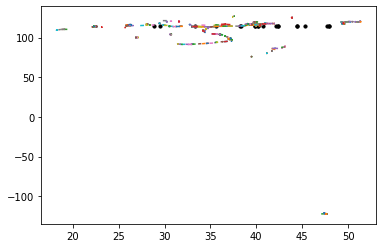

In [113]:
for i in range(len(data)):
    plt.plot(data[i][0][:,0], data[i][0][:,1]);

plt.scatter(Q[:,0], Q[:,1], s = 10, color = "black")
plt.show()

### Experience with feature mapping $\phi_3 = v_Q$

In [74]:
Data = featureMapping3(data, Q)
train, test = trainTestSplit(Data)
X = localModel(train)

#### Random Forest

In [75]:
clfRF = trainRF(X, 100)
print("train accuracy =", predictViterbiDT_RF(train, clfRF)[1])
print("test accuracy =", predictViterbiDT_RF(test, clfRF)[1]) # 0.7643665368206269 (66/33)

train accuracies for local classifiers given x_i and y_{i-1} =
[1. 1. 1. 1. 1.]
train accuracy = 1.0
test accuracy = 0.7832714329928815


### Experience with feature mapping $\phi_4 = v_Q$ + $\phi_1$

In [102]:
Data = featureMapping4(data, Q[:20])
train, test = trainTestSplit(Data)
X = localModel(train)

#### Random Forest

In [88]:
clfRF = trainRF(X, 80)
print("train accuracy =", predictViterbiDT_RF(train, clfRF)[1])
print("test accuracy =", predictViterbiDT_RF(test, clfRF)[1]) # 0.8289371174179188 (66/33)

train accuracies for local classifiers given x_i and y_{i-1} =
[1. 1. 1. 1. 1.]
train accuracy = 1.0
test accuracy = 0.8499380996595481


### Experience with feature mapping $\phi_5 = v_Q$ + $\phi_2$

In [90]:
Data = featureMapping5(data, Q)
train, test = trainTestSplit(Data)
X = localModel(train)

#### Random Forest

In [91]:
clfRF = trainRF(X, 120)
print("train accuracy =", predictViterbiDT_RF(train, clfRF)[1])
print("test accuracy =", predictViterbiDT_RF(test, clfRF)[1]) 

train accuracies for local classifiers given x_i and y_{i-1} =
[1. 1. 1. 1. 1.]
train accuracy = 1.0
test accuracy = 0.8479727638502011
